In [1]:
import mne
import mne_nirs
import matplotlib.pylab as plt
import numpy as np
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm
from nilearn.plotting import plot_design_matrix
np.random.seed(1)

In [15]:
sfreq = 3.
amp = 4.

from mne.io.snirf import read_raw_snirf
%matplotlib qt
raw = read_raw_snirf('../data_hojjat/finger_tap/40.snirf')
# raw = mne_nirs.simulation.simulate_nirs_raw(
    # sfreq=sfreq, sig_dur=60 * 5, amplitude=amp, isi_min=15., isi_max=45.)
raw.plot(n_channels=16,  show_scrollbars=True, scalings='auto');

Loading /home/kernel/Desktop/py_test/project/kernel_stuff/../data_hojjat/finger_tap/40.snirf
Opening raw-browser...


/home/kernel/Desktop/py_test/project/venv/lib/python3.8/site-packages/mne/viz/utils.py:1241: RuntimeWarning: Mean of empty slice
  this_data -= np.nanmean(this_data, 0)  # subtract segment means
/home/kernel/Desktop/py_test/project/venv/lib/python3.8/site-packages/mne/viz/_figure.py:348: RuntimeWarning: Mean of empty slice
  data -= np.nanmean(data, axis=1, keepdims=True)


Closing raw-browser...
Channels marked as bad:
none


<AxesSubplot:xlabel='onset', ylabel='description'>

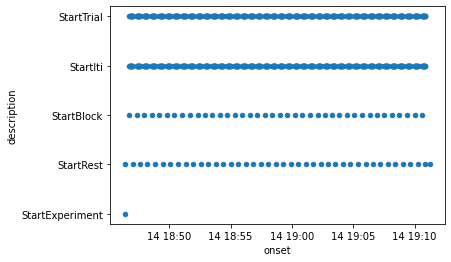

In [18]:
%matplotlib inline
raw.annotations.to_data_frame().plot.scatter(x='onset', y='description')

In [26]:
sci = mne.preprocessing.nirs.scalp_coupling_index(raw)
sci

RuntimeError: Scalp coupling index should be run on optical density data.

Effective window size : 286.925 (s)


/home/kernel/Desktop/py_test/project/venv/lib/python3.8/site-packages/mne/time_frequency/psd.py:19: RuntimeWarning: Mean of empty slice
  spect = np.nanmean(spect, axis=-1)


Effective window size : 286.925 (s)


ValueError: Some of the values  to be plotted are NaN.

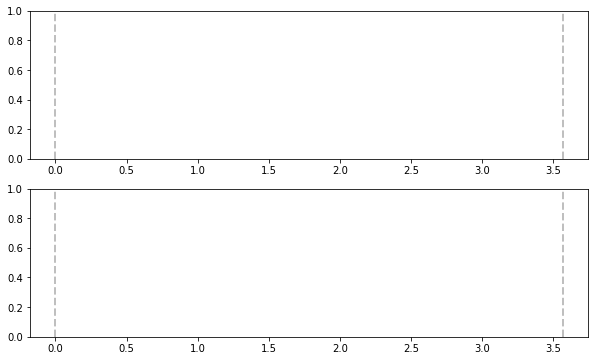

In [30]:
raw.plot_psd(average=False)

In [25]:
raw.copy().pick('S1_D1')

ValueError: picks ('S1_D1') could not be interpreted as channel names (no channel "['S1_D1']"), channel types (no type "S1_D1"), or a generic type (just "all" or "data")

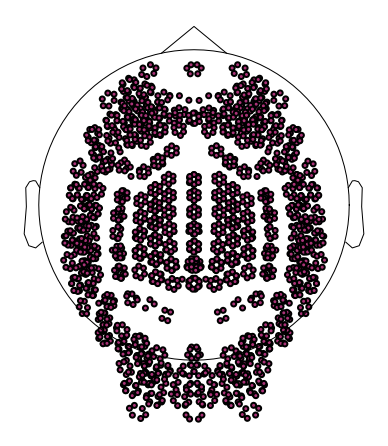

In [12]:
raw.plot_sensors();

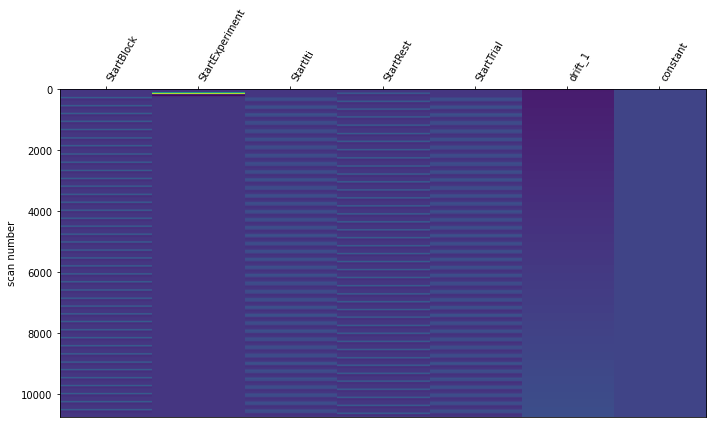

In [3]:
design_matrix = make_first_level_design_matrix(raw, stim_dur=5.0,
                                               drift_order=1,
                                               drift_model='polynomial')
fig, ax1 = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
fig = plot_design_matrix(design_matrix, ax=ax1)

In [5]:
glm_est = run_glm(raw, design_matrix)


def print_results(glm_est, truth):
    """Function to print the results of GLM estimate"""
    print("Estimate:", glm_est.theta()[0][0],
          "  MSE:", glm_est.MSE()[0],
          "  Error (uM):", 1e6*(glm_est.theta()[0][0] - truth * 1e-6))

print_results(glm_est, amp)

Estimate: [0.06490796]   MSE: 0.20224647177934102   Error (uM): [64903.9606613]


In [10]:
glm_est.theta()[0]

array([[ 0.06490796],
       [-1.22737388],
       [-0.0303393 ],
       [ 0.00242374],
       [ 0.07439886],
       [-0.07581224],
       [-0.10853271]])

In [ ]:
glm_est.plot_topo(conditions=['StartBlock']);

In [ ]:
glm_est.scatter(conditions=['StartBlock'])

In [ ]:
glm_est.surface_projection(chroma='hbo', condition='StartBlock');

In [ ]:
# First take a copy of noise free data for comparison
raw_noise_free = raw.copy()

raw._data += np.random.normal(0, np.sqrt(1e-11), raw._data.shape)
glm_est = run_glm(raw, design_matrix)

plt.plot(raw.times, raw_noise_free.get_data().T * 1e6)
plt.plot(raw.times, raw.get_data().T * 1e6, alpha=0.3)
plt.plot(raw.times, glm_est.theta()[0][0] * design_matrix["A"].values * 1e6)
plt.xlabel("Time (s)")
plt.ylabel("Haemoglobin (uM)")
plt.legend(["Clean Data", "Noisy Data", "GLM Estimate"])

print_results(glm_est, amp)